# Predicting HealthCare Claim Denial Reasons

Nicole T Blok, PhD

In [371]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
df = pd.read_csv('../data/claim.sample.csv',low_memory=False)

Given:  "We are interested in ... claims that would be denied with the following Denial.Reason.Code: F13, J8G, JO5, JB8, JE1, JC9, JF1, JF9, JG1, JPA and JES."

Assumptions:  
(1) The sample healthcare claims data represents a snapshot of claims at various stages during claims processing.
(2) Claims can be denied at any time during processing when appropriate conditions are met.
(3) When the denial reason code is missing, the claim is currently not denied.
(4) This is a multi-classification problem:
    0 = Claim is currently not denied,
    1 = Claim is currently denied for a target reason,
    2 = Claim is currenlty denied for other reasons

In [116]:
target_denialReasonCode = 'F13, J8G, JO5, JB8, JE1, JC9, JF1, JF9, JG1, JPA, JES'
target_denialReasonCode = target_denialReasonCode.split(',')
target_denialReasonCode = [cd.strip() for cd in target_denialReasonCode]
print target_denialReasonCode

#The possible Denial.Reason.Code values: missing, target_denialReasonCode and other non-missing
def tag_target(code):
    if code.strip() == '':
        return 0
    elif code in target_denialReasonCode:
        return 1
    else: 
        return 2

['F13', 'J8G', 'JO5', 'JB8', 'JE1', 'JC9', 'JF1', 'JF9', 'JG1', 'JPA', 'JES']


# Pre-Processing

In [117]:
#Store original column names in list
colnames = list(df.columns)
print "Number of columns: %i" %(len(colnames))

Number of columns: 29


In [118]:
print colnames

['Unnamed: 0', 'Claim.Number', 'Claim.Line.Number', 'Member.ID', 'Provider.ID', 'Line.Of.Business.ID', 'Revenue.Code', 'Service.Code', 'Place.Of.Service.Code', 'Procedure.Code', 'Diagnosis.Code', 'Claim.Charge.Amount', 'Denial.Reason.Code', 'Price.Index', 'In.Out.Of.Network', 'Reference.Index', 'Pricing.Index', 'Capitation.Index', 'Subscriber.Payment.Amount', 'Provider.Payment.Amount', 'Group.Index', 'Subscriber.Index', 'Subgroup.Index', 'Claim.Type', 'Claim.Subscriber.Type', 'Claim.Pre.Prince.Index', 'Claim.Current.Status', 'Network.ID', 'Agreement.ID']


In [413]:
df_denialReasonCodes = pd.DataFrame(df.groupby('Denial.Reason.Code').apply(
    lambda x: np.size(x['Denial.Reason.Code']))).reset_index()
df_denialReasonCodes.columns = ['Denial.Reason.Code','Frequency']
print df_denialReasonCodes.shape
df_denialReasonCodes.head(10)

(259, 2)


,Denial.Reason.Code,Frequency
0,,326030
1,002,30
2,003,46
3,017,3
4,018,1
5,019,242
6,060,1
7,073,33
8,104,44
9,319,16


In [119]:
#Give the claim a label according to the denial reason code 
df['target'] = df.apply(lambda x: 
    tag_target(x['Denial.Reason.Code']), axis=1)

In [120]:
print "Frequency of target label among claim records"
df.groupby('target').apply(lambda x: np.size(x.target))

Frequency of target label among claim records


target
0    326030
1      1971
2    144558
dtype: int64

In [217]:
def flag_missing(value):
    if type(value) == str:
        if value.strip() == '':
            return 'Missing'
        else:
            return 'Not Missing'
    else:
        if str(value) == 'nan':
            return 'Missing'
        else:
            return 'Not Missing'

In [414]:
#Count of missing values among features
features = [nm for nm in colnames if nm not in ['Unnamed: 0','Denial.Reason.Code']]
for feature in features:
    df['missing'] = df.apply(lambda x: flag_missing(x[feature]), axis=1)
    missing = pd.DataFrame(df.groupby('missing').apply(lambda x: np.size(x.missing))).reset_index()
    missing.columns = [feature,'Count']
    missing['Pct_missing'] = missing.apply(lambda x: int(100*x.Count/float(472559)), axis=1)
    print missing
    print '------------'
    print

  Claim.Number   Count  Pct_missing
0      Missing  174023           36
1  Not Missing  298536           63
------------

  Claim.Line.Number   Count  Pct_missing
0       Not Missing  472559          100
------------

     Member.ID   Count  Pct_missing
0  Not Missing  472559          100
------------

   Provider.ID   Count  Pct_missing
0  Not Missing  472559          100
------------

  Line.Of.Business.ID   Count  Pct_missing
0             Missing  207509           43
1         Not Missing  265050           56
------------

  Revenue.Code   Count  Pct_missing
0      Missing     356            0
1  Not Missing  472203           99
------------

  Service.Code   Count  Pct_missing
0      Missing     546            0
1  Not Missing  472013           99
------------

  Place.Of.Service.Code   Count  Pct_missing
0               Missing  472156           99
1           Not Missing     403            0
------------

  Procedure.Code   Count  Pct_missing
0        Missing  175631           3

In [221]:
exclude_features = ['Claim.Number','Member.ID','Line.Of.Business.ID','Place.Of.Service.Code',
                   'Procedure.Code','Price.Index','Reference.Index',
                   'Pricing.Index','Capitation.Index','Claim.Pre.Prince.Index',
                   'Network.ID','Agreement.ID']
impute_features = ['Revenue.Code','Service.Code','In.Out.Of.Network']
keep_features = ['Claim.Line.Number','Provider.ID','Diagnosis.Code','Claim.Charge.Amount',
                'Subscriber.Payment.Amount','Provider.Payment.Amount','Group.Index',
                'Subscriber.Index','Claim.Type','Claim.Subscriber.Type','Claim.Current.Status']

In [223]:
#List String Keep Features
obj_features = pd.DataFrame(df[keep_features+impute_features].dtypes).reset_index()
obj_features.columns = ['features','dtype']
obj_features = obj_features[obj_features['dtype']=='object']
obj_features = list(obj_features.features)
obj_features

['Provider.ID',
 'Diagnosis.Code',
 'Claim.Type',
 'Claim.Subscriber.Type',
 'Revenue.Code',
 'Service.Code',
 'In.Out.Of.Network']

In [224]:
df[obj_features].head(10)

,Provider.ID,Diagnosis.Code,Claim.Type,Claim.Subscriber.Type,Revenue.Code,Service.Code,In.Out.Of.Network
0,FA0001411002,V5789,M,H,0128,RR8I,I
1,FA0001411002,V5789,M,H,0024,AL7I,I
2,FA0001411002,V5789,M,H,0128,RR8I,I
3,FA0001411002,V5789,M,H,0250,AL7I,I
4,FA0001411002,V5789,M,H,0258,AL7I,I
5,FA0001411002,V5789,M,H,0259,AL7I,I
6,FA0001411002,V5789,M,H,0271,AL7I,I
7,FA0001411002,V5789,M,H,0300,AL7I,I
8,FA0001411002,V5789,M,H,0301,AL7I,I
9,FA0001411002,V5789,M,H,0305,AL7I,I


# Model Building 
Gradient Boosting Classifier (GBC)

In [226]:
#Use marker values for missing values
def mark_missing(value):
    if value.strip() == '':
        return 'UNKNOWN'
    else: return value.strip()

In [228]:
for feature in impute_features:
    df['imp_'+feature] = df.apply(lambda x: mark_missing(x[feature]), axis=1)

In [229]:
keep = keep_features + ['imp_'+feature for feature in impute_features]

In [230]:
df[keep].head(10)

,Claim.Line.Number,Provider.ID,Diagnosis.Code,Claim.Charge.Amount,Subscriber.Payment.Amount,Provider.Payment.Amount,Group.Index,Subscriber.Index,Claim.Type,Claim.Subscriber.Type,Claim.Current.Status,imp_Revenue.Code,imp_Service.Code,imp_In.Out.Of.Network
0,1,FA0001411002,V5789,19356.960000,0,15036.210000,110,7763000,M,H,2,0128,RR8I,I
1,1,FA0001411002,V5789,0.000000,0,0.000000,110,20421600,M,H,91,0024,AL7I,I
2,2,FA0001411002,V5789,27099.744000,0,27525.263805,110,20421600,M,H,91,0128,RR8I,I
3,3,FA0001411002,V5789,2262.097800,0,0.000000,110,20421600,M,H,91,0250,AL7I,I
4,4,FA0001411002,V5789,284.712735,0,0.000000,110,20421600,M,H,91,0258,AL7I,I
5,5,FA0001411002,V5789,1081.397310,0,0.000000,110,20421600,M,H,91,0259,AL7I,I
6,6,FA0001411002,V5789,38.146050,0,0.000000,110,20421600,M,H,91,0271,AL7I,I
7,7,FA0001411002,V5789,148.140000,0,0.000000,110,20421600,M,H,91,0300,AL7I,I
8,8,FA0001411002,V5789,564.166500,0,0.000000,110,20421600,M,H,91,0301,AL7I,I
9,9,FA0001411002,V5789,1180.182000,0,0.000000,110,20421600,M,H,91,0305,AL7I,I


In [231]:
#Label encode string features
obj_features = pd.DataFrame(df[keep].dtypes).reset_index()
obj_features.columns = ['features','dtype']
obj_features = obj_features[obj_features['dtype']=='object']
obj_features = list(obj_features.features)

label_encoder = preprocessing.LabelEncoder()
X_df = df[keep].copy()
for obj_feature in obj_features:
    X_df[obj_feature] = label_encoder.fit_transform(X_df[obj_feature])

In [236]:
y = df['target'].as_matrix().astype(np.float)
X = X_df.as_matrix().astype(np.float)
print X.shape
print y.shape

(472559, 14)
(472559,)


In [237]:
#Scale features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.79518217,  0.64945021,  1.47389088, ..., -1.78760256,
         1.16161327, -0.88169005],
       [-0.79518217,  0.64945021,  1.47389088, ..., -2.20407673,
        -1.39141404, -0.88169005],
       [-0.71381231,  0.64945021,  1.47389088, ..., -1.78760256,
         1.16161327, -0.88169005],
       ..., 
       [ 0.34399588,  0.39045638,  0.6876856 , ...,  1.1797759 ,
         0.27156705, -0.88169005],
       [ 0.42536574,  0.39045638,  0.6876856 , ...,  1.1797759 ,
         0.27156705, -0.88169005],
       [ 0.5067356 ,  0.39045638,  0.6876856 , ...,  1.1797759 ,
         0.27156705, -0.88169005]])

In [238]:
#Step 1: Create Training dataset with 60% of data
sss = cross_validation.StratifiedShuffleSplit(y,n_iter=1, test_size=0.4, random_state=0)
for train_i, test_i in sss:
    print "Train:", train_i, "Test:", test_i
    X_train,X_test = X[train_i], X[test_i]
    y_train,y_test = y[train_i],y[test_i]

Train: [293770 344846  78194 ..., 446701 145929  90430] Test: [264364 446500 184862 ...,  56902 174282  84349]


In [242]:
#Step 2: Further split Testing dataset into 20% of data for testing and 20% for cross-validation
sss = cross_validation.StratifiedShuffleSplit(y_test,n_iter=1, test_size=0.5, random_state=1)
for train_i, test_i in sss:
    print "Train:", train_i, "Test:", test_i
    X_test,X_cv = X_test[train_i], X_test[test_i]
    y_test,y_cv = y_test[train_i],y_test[test_i]

print 
print "DATASETS:"
print "Training : X_train (%i,%i) with labels y_train (%i)" %(X_train.shape[0],X_train.shape[0],
                                                             y_train.shape[0])
print
print "Testing  : X_test (%i,%i) with labels y_test  (%i)" %(X_test.shape[0],X_test.shape[0],
                                                             y_test.shape[0])
print
print "Cross-Val: X_cv   (%i,%i) with labels y_cv    (%i)" %(X_cv.shape[0],X_cv.shape[0],
                                                             y_cv.shape[0])

Train: [12351  4553  8216 ...,  4315 16063 15323] Test: [ 4436 18955 10579 ..., 16941   637 19090]

DATASETS:
Training : X_train (283536,283536) with labels y_train (283536)

Testing  : X_test (11813,11813) with labels y_test  (11813)

Cross-Val: X_cv   (11813,11813) with labels y_cv    (11813)


In [244]:
#Find out accuracy score for predicting all target = 0
print "Predict all 0: {:.2f}".format(metrics.accuracy_score(y,[0 for ii in y.tolist()]))

Predict all 0: 0.69


In [247]:
#Take head X_train, y_train for quick run to test model syntax and data quality
head_X = X_train[:1000,:]
head_y = y_train[:1000]
n_est=300
learn_rt=0.3
max_d=5
rand_st=0
clf = GradientBoostingClassifier(n_estimators=n_est,
                                learning_rate=learn_rt,
                                max_depth=max_d,
                                random_state=rand_st).fit(head_X,head_y)
clf.score(X_test,y_test)

0.87886227038008968

In [248]:
#Try model with complete training set
n_est=300
learn_rt=0.3
max_d=5
rand_st=0
clf = GradientBoostingClassifier(n_estimators=n_est,
                                learning_rate=learn_rt,
                                max_depth=max_d,
                                random_state=rand_st).fit(X_train,y_train)
clf.score(X_test,y_test)

0.94963176161855578

In [355]:
sample_n = len(y_train)
n_pct_1 = int(sample_n*.01)
n_pct_5 = int(sample_n*.05)
n_pct_10 = int(sample_n*.10)

2835.36

In [356]:
#Optimize model parameters with quick training set to see parameter trends with score
sample_n = len(y_train)
n_pct_1 = int(sample_n*.01)
n_pct_5 = int(sample_n*.05)
n_pct_10 = int(sample_n*.10)
sample_n_s = [n_pct_1,n_pct_5,n_pct_10]

n_est_s = [50,100,200,300,500]
learn_rt_s = [0.1,0.2,0.3,0.4,0.5]
max_d_s = [2,3,4,5,6]
sample_clf_scores = []; sample_params = []
for n in sample_n_s:
    head_X = X_train[:n,:]
    head_y = y_train[:n]
    clf_scores = []; params = []
    for n_est in n_est_s:
        for learn_rt in learn_rt_s:
            for max_d in max_d_s:
                clf = GradientBoostingClassifier(n_estimators=n_est,
                                learning_rate=learn_rt,
                                max_depth=max_d,
                                random_state=rand_st).fit(head_X,head_y)
                clf_score = clf.score(X_test,y_test)
                clf_scores.append(clf_score)
                params.append((n_est,learn_rt,max_d))
    sample_clf_scores.append(clf_scores)
    sample_params.append(params)

In [360]:
colors = ['blue','red','green','pink','yellow']
shapes = ['o','^','s','x','d']
fills = ['full','full','none','none','none']
def define_color_shape(learn_rt,max_d):
    shape = [shapes[i] for i in range(len(shapes)) if learn_rt == learn_rt_s[i]][0]
    fill = [fills[i] for i in range(len(fills)) if learn_rt == learn_rt_s[i]][0]
    color = [colors[i] for i in range(len(colors)) if max_d == max_d_s[i]][0]
    label = 'learning-rate='+str(learn_rt)+', max-depth='+str(max_d)
    return (shape,fill,color,label)

In [361]:
def plot_scores(params,clf_scores,sample_n):
    plt_symbols = [define_color_shape(params[i][1],params[i][2]) for i in range(len(params))]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(len(plt_symbols)):
        plt.scatter(params[i][0],clf_scores[i],
            marker = plt_symbols[i][0],
            color=plt_symbols[i][2],
            label=plt_symbols[i][3]
           )
    plt.xlabel('Number of Estimators')
    plt.ylabel('Score')
    title = "Sample Size = %i" %(sample_n)
    plt.title(title)
    handles, labels = ax.get_legend_handles_labels()
    uniq_handles = list(set(handles))
    uniq_labels = list(set(labels))
    ax.legend(uniq_handles, labels=uniq_labels, loc='upper right', 
          numpoints=1, ncol=1, fontsize=8, bbox_to_anchor=(1.6,1))
    plt.show()

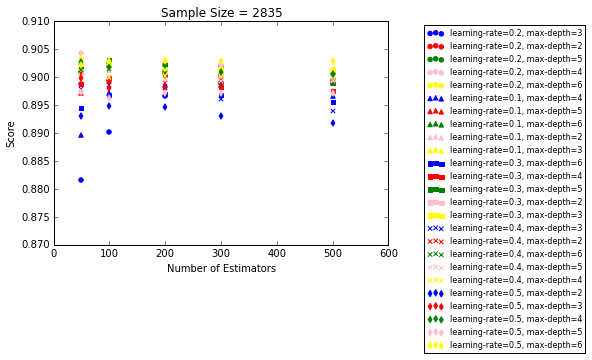

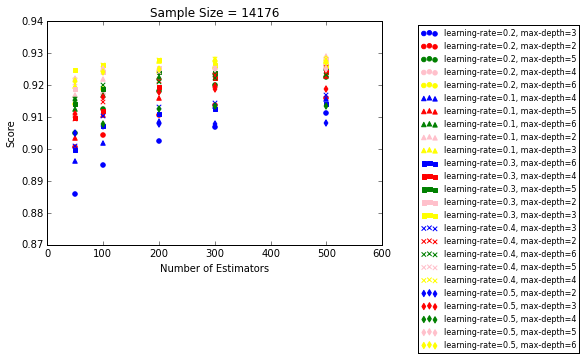

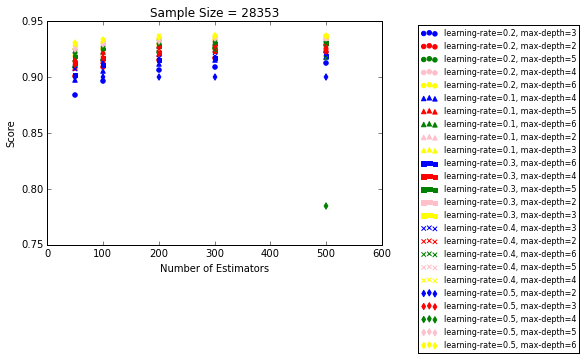

In [362]:
for i_n in range(len(sample_n_s)):
    sample_n = sample_n_s[i_n]
    params = sample_params[i_n]
    clf_scores = sample_clf_scores[i_n]
    plot_scores(params,clf_scores,sample_n)

Best score results with increasing samples size: number of estimators = 250, learning rate = 0.5, max depth = 6

In [363]:
#Try model with complete training set and optimized parameters
n_est=250
learn_rt=0.5
max_d=6
rand_st=0
clf = GradientBoostingClassifier(n_estimators=n_est,
                                learning_rate=learn_rt,
                                max_depth=max_d,
                                random_state=rand_st).fit(X_train,y_train)
clf.score(X_test,y_test)

0.95530347921781089

In [367]:
#Train final model with X_train+X_test and test with X_cv
X_fi = np.vstack((X_train,X_test))
y_fi = np.hstack((y_train,y_test))
print X_fi.shape
print y_fi.shape

(295349, 14)
(295349,)


In [368]:
n_est=250
learn_rt=0.5
max_d=6
rand_st=0
clf = GradientBoostingClassifier(n_estimators=n_est,
                                learning_rate=learn_rt,
                                max_depth=max_d,
                                random_state=rand_st).fit(X_fi,y_fi)
clf.score(X_cv,y_cv)

0.95674257174299504

#Estimator score from cross-validation data = 0.9567

#Model Evaluation

In [380]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

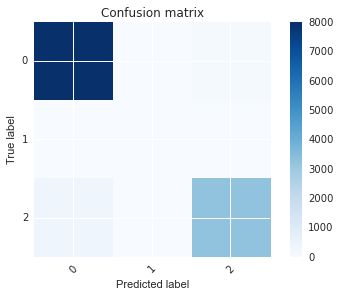

In [381]:
#Confusion matrix using sklearn example
cm = metrics.confusion_matrix(y_cv, clf.predict(X_cv))
plt.figure()
plot_confusion_matrix(cm,target_names = [0,1,2])
plt.show()

In [393]:
def sns_plot_confusion_matrix(cm, target_names, title='Confusion matrix'):
    plt.title(title)
    sns.heatmap(cm, annot=True, fmt='')
    sns.axlabel(xlabel='Predicted label', ylabel='True label')

# Seaborn - Confusion Matrix

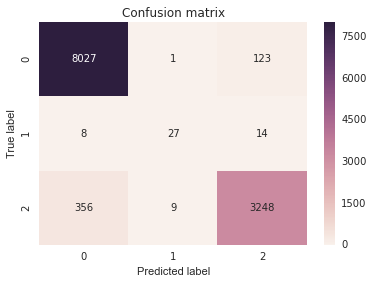

In [394]:
sns_plot_confusion_matrix(cm, target_names = [0,1,2], 
                          title='Confusion matrix')

In [400]:
target_names = ['0: Not yet denied', 
                '1: Target denied ', 
                '2: Other denied  ']
print metrics.classification_report(y_cv, clf.predict(X_cv), target_names=target_names)

                   precision    recall  f1-score   support

0: Not yet denied       0.96      0.98      0.97      8151
1: Target denied        0.73      0.55      0.63        49
2: Other denied         0.96      0.90      0.93      3613

      avg / total       0.96      0.96      0.96     11813



In [412]:
sp = 100*float(8+14)/float(8+9+14)
print "Specificity (True Negative Rate) of class, %sTarget denied%s: %.0f%%" %('"','"',sp)

Specificity (True Negative Rate) of class, "Target denied": 71%


Sensitivity (True Positive Rate) of class, "Target denied" (=Recall): 55%